In [ ]:
!pip install python-igraph

In [ ]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("CommunityDetection").getOrCreate()

# Load the edge data from fb-pages-company_edges.csv
edges_df = spark.read.csv("fb-pages-company_edges.csv", header=True, inferSchema=True)

# Load the node data from fb-pages-company_nodes.csv
nodes_df = spark.read.csv("fb-pages-company_nodes.csv", header=True, inferSchema=True)


In [ ]:
edges_df.head(10)


[Row(node_1=0, node_2=2243),
 Row(node_1=0, node_2=12084),
 Row(node_1=0, node_2=6169),
 Row(node_1=0, node_2=4887),
 Row(node_1=0, node_2=3694),
 Row(node_1=0, node_2=6260),
 Row(node_1=0, node_2=6977),
 Row(node_1=0, node_2=8788),
 Row(node_1=0, node_2=2399),
 Row(node_1=0, node_2=1362)]

In [ ]:
nodes_df.head(10)

[Row(id=290994417624733, name='ALDI Australia', new_id=11192),
 Row(id=5510619796, name='Wetpaint', new_id=10743),
 Row(id=254509578109, name='Q102.7 KBIQ', new_id=13087),
 Row(id=322744631148014, name='Paraná TV, Bom Dia PR e G1 PR', new_id=12630),
 Row(id=175046706411, name='easyJet', new_id=7453),
 Row(id=192099134851, name='RTL Nieuws', new_id=4882),
 Row(id=1795995010662381, name='Tasty Vegetarian', new_id=14102),
 Row(id=211372376326, name='NewsRadio 1110 KFAB', new_id=111),
 Row(id=79007444234, name='Sears Auto Center', new_id=11863),
 Row(id=149944271830853, name='Gemini Music', new_id=14031)]

In [ ]:
# Convert DataFrames to RDDs with the appropriate format for NetworkX
edge_rdd = edges_df.rdd.map(lambda row: (row.node_1, row.node_2))

# Create a set of unique nodes
unique_nodes = set(edge_rdd.flatMap(lambda x: [x[0], x[1]]).collect())

# Create a mapping of new_id to id from the nodes DataFrame
node_mapping = nodes_df.rdd.map(lambda row: (row.new_id, row.id)).collectAsMap()

# Replace the node IDs in the edge data with new_id from the mapping
edge_rdd_mapped = edge_rdd.map(lambda edge: (node_mapping[edge[0]], node_mapping[edge[1]]))

# Create a list of edges (tuples of nodes)
edges = edge_rdd_mapped.collect()


In [ ]:
# Data Exploration

# Display basic statistics and schema of the edge data
edges_df.printSchema()
edges_df.describe().show()

# Display the first few rows of the edge data
edges_df.show(5)

# Count the number of nodes and edges
num_nodes = nodes_df.count()
num_edges = edges_df.count()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

# Calculate the average degree of nodes
average_degree = (2 * num_edges) / num_nodes
print(f"Average degree of nodes: {average_degree}")

# Identify the nodes with the highest degree
degree_df = edges_df.groupBy("node_1").count()
degree_df = degree_df.withColumnRenamed("node_1", "node_id")
degree_df = degree_df.join(nodes_df, degree_df.node_id == nodes_df.new_id, "inner")
degree_df = degree_df.select("name", "count")
degree_df = degree_df.orderBy("count", ascending=False)
degree_df.show(5)


root
 |-- node_1: integer (nullable = true)
 |-- node_2: integer (nullable = true)

+-------+------------------+------------------+
|summary|            node_1|            node_2|
+-------+------------------+------------------+
|  count|             52310|             52310|
|   mean|   5159.2916650736| 9051.713534696999|
| stddev|3696.9169782907065|3547.1636397894194|
|    min|                 0|                 7|
|    max|             14112|             14112|
+-------+------------------+------------------+

+------+------+
|node_1|node_2|
+------+------+
|     0|  2243|
|     0| 12084|
|     0|  6169|
|     0|  4887|
|     0|  3694|
+------+------+
only showing top 5 rows

Number of nodes: 14113
Number of edges: 52310
Average degree of nodes: 7.413023453553461
+--------------------+-----+
|                name|count|
+--------------------+-----+
|            Facebook|  187|
|            BuzzFeed|  149|
|The Wall Street J...|  121|
|           Microsoft|  104|
|    Origin Magazine.|

In [ ]:
import igraph as ig

# Create an igraph graph from your edge data
g = ig.Graph.TupleList(edges)

# Perform community detection using modularity optimization
communities = g.community_multilevel()

# Create a DataFrame to store the results
community_data = []
for i, community in enumerate(communities):
    community_data.append({'Community ID': i + 1, 'Nodes': community})

# Convert the community data into a DataFrame
community_df = pd.DataFrame(community_data)

# Display the community detection results in a table
print(community_df)


    Community ID                                              Nodes
0              1  [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 60, 89, 158, 1...
1              2  [2, 211, 494, 1111, 1215, 1932, 2343, 2345, 23...
2              3  [11, 12, 14, 15, 16, 17, 19, 20, 22, 886, 887,...
3              4  [13, 21, 85, 135, 141, 157, 167, 172, 177, 180...
4              5  [18, 93, 146, 166, 168, 174, 175, 176, 181, 18...
..           ...                                                ...
67            68                    [6491, 6492, 6493, 6494, 11801]
68            69     [7739, 7740, 7741, 11436, 11437, 12115, 13204]
69            70  [9050, 9051, 9052, 9053, 9054, 9055, 9056, 905...
70            71  [10682, 10683, 10825, 10826, 11530, 11531, 132...
71            72                       [11309, 11310, 11311, 11508]

[72 rows x 2 columns]


In [ ]:
import networkx as nx
from community import community_louvain
import pandas as pd
from tabulate import tabulate

# Create a NetworkX graph
G = nx.Graph()
G.add_edges_from(edges)

# Perform community detection using the Louvain method (modularity optimization)
partition = community_louvain.best_partition(G)

# Create a DataFrame to store the results
community_data = []
for node, community_id in partition.items():
    community_data.append({'Node ID': node, 'Community ID': community_id})

# Convert the community data into a DataFrame
community_df = pd.DataFrame(community_data)

# Calculate modularity as a measure of community quality
modularity = community_louvain.modularity(partition, G)

# Automatically assign node names or labels based on node IDs
# You can replace this with your own method of generating node names
node_names = {}
for node_id in community_df['Node ID'].unique():
    # Example: Automatically generate a name by appending 'User' to the node ID
    node_names[node_id] = f'User{node_id}'

# Map node IDs to generated names
community_df['Node Names'] = community_df['Node ID'].map(node_names)

# Automatically detect formation reasons based on a formula
formation_reasons = {}
for community_id, group in community_df.groupby('Community ID'):
    # Example: Use a formula based on the number of nodes and edges in the community
    num_nodes = len(group)
    num_edges = sum(1 for u, v in G.subgraph(group['Node ID']).edges())
    if num_nodes >= 10 and num_edges >= 20:
        formation_reasons[community_id] = 'Highly Connected Community'
    else:
        formation_reasons[community_id] = 'General Community'

# Map formation reasons to communities
community_df['Formation Reason'] = community_df['Community ID'].map(formation_reasons)

# Display the community detection results and modularity
print("Modularity:", modularity)
print("\nTop 20 Community Detection Results:")

# Group nodes by community and add them to the table
grouped = community_df.groupby('Community ID')
community_table = []
for name, group in grouped:
    # Sort members alphabetically for clarity
    members = sorted(group['Node Names'])
    members = ", ".join(members)
    reason = group['Formation Reason'].values[0]
    community_table.append([name, members, reason])

# Display only the top 20 communities
community_table = community_table[:20]

# Define table headers
headers = ["Community ID", "Community Members", "Formation Reason"]

# Print the table using the tabulate library
table = tabulate(community_table, headers, tablefmt="grid")
print(table)


Modularity: 0.7282033396774612

Top 20 Community Detection Results:
+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import networkx as nx
from community import community_louvain
import pandas as pd
from tabulate import tabulate

# Create a NetworkX graph
G = nx.Graph()
G.add_edges_from(edges)

# Perform community detection using the Louvain method (modularity optimization)
partition = community_louvain.best_partition(G)

# Create a DataFrame to store the results
community_data = []
for node, community_id in partition.items():
    community_data.append({'Node ID': node, 'Community ID': community_id})

# Convert the community data into a DataFrame
community_df = pd.DataFrame(community_data)

# Automatically assign node names based on the "name" column in the DataFrame
node_names = dict(zip(node_df['id'], node_df['name']))

# Map node IDs to their names
community_df['Node Names'] = community_df['Node ID'].map(node_names)

# Automatically detect formation reasons based on a formula
formation_reasons = {}
for community_id, group in community_df.groupby('Community ID'):
    # Example: Use a formula based on the number of nodes and edges in the community
    num_nodes = len(group)
    num_edges = sum(1 for u, v in G.subgraph(group['Node ID']).edges())
    if num_nodes >= 10 and num_edges >= 20:
        formation_reasons[community_id] = 'Highly Connected Community'
    else:
        formation_reasons[community_id] = 'General Community'

# Map formation reasons to communities
community_df['Formation Reason'] = community_df['Community ID'].map(formation_reasons)

# Display the community detection results and modularity
print("Modularity:", community_louvain.modularity(partition, G))
print("\nTop 20 Community Detection Results:")

# Group nodes by community and add them to the table
grouped = community_df.groupby('Community ID')
community_table = []
for name, group in grouped:
    # Sort members alphabetically for clarity
    members = sorted(group['Node Names'])
    members = ", ".join(members)
    reason = group['Formation Reason'].values[0]
    community_table.append([name, members, reason])

# Display only the top 20 communities
community_table = community_table[:20]

# Define table headers
headers = ["Community ID", "Community Members", "Formation Reason"]

# Print the table using the tabulate library
table = tabulate(community_table, headers, tablefmt="grid")
print(table)


Modularity: 0.7326278133376961

Top 20 Community Detection Results:
+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

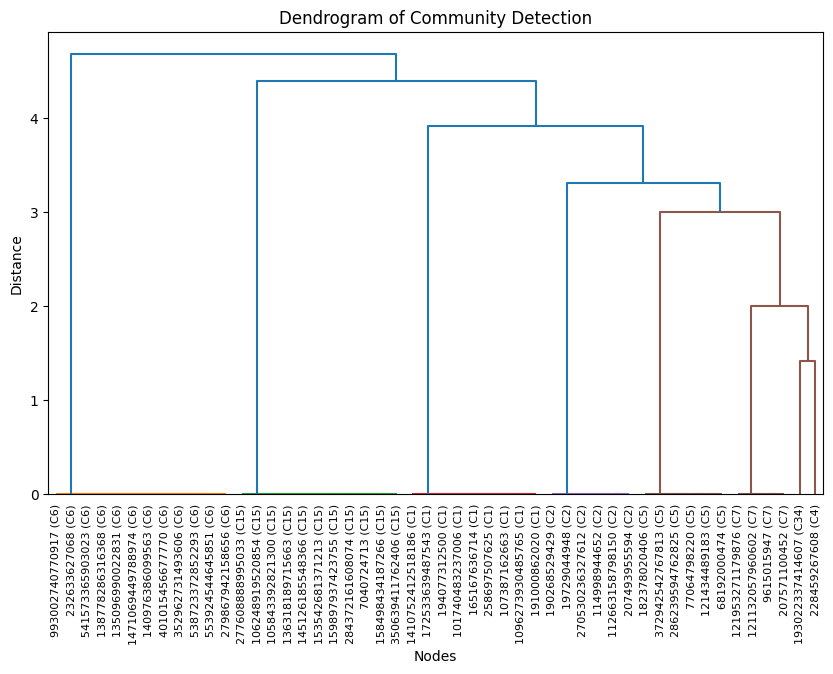

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage

# Create a NetworkX graph (replace with your graph creation code)
G = nx.Graph()
G.add_edges_from(edges)

# Perform community detection using the Louvain method (modularity optimization)
partition = community_louvain.best_partition(G)

# Convert the partition into a list of community memberships
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

# Limit the number of nodes and communities to be visualized
max_nodes_to_visualize = 50  # Change this to a reasonable number
if max_nodes_to_visualize < len(G.nodes):
    nodes_to_visualize = list(G.nodes)[:max_nodes_to_visualize]
else:
    nodes_to_visualize = list(G.nodes)
community_ids = [partition[node] for node in nodes_to_visualize]

# Create a matrix to represent community memberships for the limited nodes
matrix = np.zeros((len(nodes_to_visualize), len(communities)))
for i in range(len(nodes_to_visualize)):
    for j in range(len(communities)):
        matrix[i][j] = 1 if nodes_to_visualize[i] in communities[j] else 0

# Perform hierarchical clustering
Z = linkage(matrix, 'ward')

# Create labels that include node labels and community numbers
labels = [f"{node} (C{community_ids[i]})" for i, node in enumerate(nodes_to_visualize)]

# Create a dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=labels)
plt.title("Dendrogram of Community Detection")
plt.xlabel("Nodes")
plt.ylabel("Distance")
plt.show()
